# Importing required packages for reading and loading a json file

In [1]:
# !pip install rembg onnxruntime-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.2/283.2 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.8 MB/s eta 0:00:00


In [1]:
import json
# from rembg import remove

In [2]:
# Load the json file as data
with open("/content/grouped-products.json", "r") as f:
    data = json.load(f)

In [3]:
# Extract the image urls
specs_data = []

for specs_key, specs_info in data.get("specs", {}).items():
    product_id = specs_info.get("product_id")
    image_link = specs_info.get("image", {}).get("link")

    if product_id and image_link:
        specs_data.append((product_id, image_link))

In [4]:
# Check for number of image urls
print(len(specs_data))

20


# The OpenCV approach for removing the background from spec images starts from here

In [5]:
# Importing required packages
import requests
from io import BytesIO
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Function 1 to try removing background

In [22]:
# Define a function called remove_background_cv
def remove_background_cv_1(image_url, output_path):
  # Check the response from the supplied image url
  response = requests.get(image_url)
  # If the status code is not 200, the image url can not be read
  if response.status_code != 200:
    raise Exception(f"============ Failed to load image from ====================")
    print(response)
  # If the status code is 200, then go to the next steps
  else:
    # Read the image in PIL format, convert it into RGB and then convert it in numpy array format
    image = np.array(Image.open(BytesIO(response.content)).convert("RGB"))
    # Convert the RGB image into BGR image
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    # Initialize the mask and the model
    height, width = image_bgr.shape[:2]
    mask = np.zeros((height, width), np.uint8)
    bg_model = np.zeros((1, 65), np.float64) # Background object
    fg_model = np.zeros((1, 65), np.float64) # Foreground Object
    # Define rectangle around the object (just slightly inside the image)
    margin = int(0.02 * width)  # 2% margin
    rect = (margin, margin, width - 2*margin, height - 2*margin)
    # Apply GrabCut algorithm
    cv2.grabCut(image_bgr, mask, rect, bg_model, fg_model, 5, cv2.GC_INIT_WITH_RECT)
    # Convert mask to binary
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    # Apply OpenCv morphological operations to smooth the masks
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    mask2 = cv2.morphologyEx(mask2, cv2.MORPH_OPEN, kernel, iterations=1)
    mask2 = cv2.morphologyEx(mask2, cv2.MORPH_DILATE, kernel, iterations=1)
    # Feather edges (smooth alpha)
    blurred_alpha = cv2.GaussianBlur(mask2.astype(np.float32), (5, 5), 0)
    blurred_alpha = (blurred_alpha * 255).astype(np.uint8)
    # Apply to image
    image_cut = image_bgr.copy()
    image_rgba = cv2.cvtColor(image_cut, cv2.COLOR_BGR2RGBA)
    image_rgba[:, :, 3] = blurred_alpha
    # Save result
    result = Image.fromarray(image_rgba)
    result.save(output_path)
    print(f"Background removed. Image saved at: {output_path}")

In [23]:
# Test the function on different images
spec_url = "https://prod.titanencircle.com/on/demandware.static/-/Sites-Eyeplus-product-catalog/default/dw5cfd1099/images/FT1508UFP4MGRV_1_lar.jpg"
output_path = "/content/RemovedBg_Specs.png"
remove_background_cv_1(spec_url, output_path)

Background removed. Image saved at: /content/RemovedBg_Specs.png


# Function - 2 for trying to remove background

In [21]:
# Define a function called remove_background_cv_2
def remove_background_cv_2(image_url, output_path):
  # Check the response from the supplied image url
  response = requests.get(image_url)
  # If the status code is not 200, the image url can not be read
  if response.status_code != 200:
    raise Exception(f"============ Failed to load image from ====================")
    print(response)
  # If the status code is 200, then go to the next steps
  else:
    # Read the image in PIL format, convert it into RGB and then convert it in numpy array format
    image = np.array(Image.open(BytesIO(response.content)).convert("RGB"))
    # Convert the RGB image into BGR image
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    # Convert the image into gray scale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply golabl thresholding on the gray scale image
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
    # Apply adapting thresholding on the image
    adaptive_thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                            cv2.THRESH_BINARY, 11, 2)
    # Refine the edges with morphological operations
    kernel = np.ones((5,5), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    # Extract the foreground
    mask = np.zeros(image.shape[:2], np.uint8)
    bgd_Model = np.zeros((1, 65), np.float64)
    fgd_Model = np.zeros((1, 65), np.float64)
    # Create a rectangle for consideration
    rect = (50, 50, image.shape[1]-50, image.shape[0]-50)
    cv2.grabCut(image, mask, rect, bgd_Model, fgd_Model, 5, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0), 0, 1).astype('uint8')
    image = image*mask2[:,:,np.newaxis]
    image = Image.fromarray(image)
    image.save(output_path)
    print(f"Background removed. Image saved at: {output_path}")

In [22]:
url = "https://prod.titanencircle.com/on/demandware.static/-/Sites-Eyeplus-product-catalog/default/dw5cfd1099/images/FT1508UFP4MGRV_1_lar.jpg"
output_path = "/content/RemovedBg_Specs.png"
remove_background_cv_2(url, output_path)

Background removed. Image saved at: /content/RemovedBg_Specs.png


# Function - 3 for trying to remove background

In [23]:
!pip install rembg onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.1 MB/s eta 0:00:00


In [24]:
from rembg import remove

In [28]:
def remove_background_cv_3(image_url, output_path):
  # Check the response from the supplied image url
  response = requests.get(image_url)
  # If the status code is not 200, the image url can not be read
  if response.status_code != 200:
    raise Exception(f"============ Failed to load image from ====================")
    print(response)
  # If the status code is 200, then go to the next steps
  else:
    # Read the image in PIL format, convert it into RGB and then convert it in numpy array format
    image = np.array(Image.open(BytesIO(response.content)).convert("RGB"))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    rembg_image = remove(image)
    cv2.imwrite(output_path, rembg_image)
    print(f"Removed background. Image saved at: {output_path}")

In [30]:
url = "https://prod.titanencircle.com/on/demandware.static/-/Sites-Eyeplus-product-catalog/default/dw623fbf30/images/DK1087UFP3MORV_1_lar.jpg"
output_path = "/content/RemovedBg_Specs.png"
remove_background_cv_3(url, output_path)

Removed background. Image saved at: /content/RemovedBg_Specs.png


# Function - 4 to remove background from images

In [8]:
# Importing required packages
import cv2
import torch
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO

In [9]:
# Define a function to load a model
def load_model():
  model = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True)
  model.eval()
  return model

In [16]:
# Define a function to make the foreground transparent
def make_transparent_foreground(image, mask):
  # split the image into channels
  b, g, r = cv2.split(np.array(image).astype('uint8'))
  # add an alpha channel with and fill all with transparent pixels (max 255)
  a = np.ones(mask.shape, dtype='uint8') * 255
  # merge the alpha channel back
  alpha_im = cv2.merge([b, g, r, a], 4)
  # create a transparent background
  bg = np.zeros(alpha_im.shape)
  # setup the new mask
  new_mask = np.stack([mask, mask, mask, mask], axis=2)
  # copy only the foreground color pixels from the original image where mask is set
  foreground = np.where(new_mask, alpha_im, bg).astype(np.uint8)
  return foreground

In [17]:
# Define the main function to extract the foreground and backgroud separately
def remove_background(model, image_url):
  response = requests.get(image_url)
  input_image = Image.open(BytesIO(response.content)).convert("RGB")
  preprocess = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                        std=[0.229, 0.224, 0.225]),])

  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

  # move the input and model to GPU for speed if available
  if torch.cuda.is_available():
      input_batch = input_batch.to('cuda')
      model.to('cuda')

  with torch.no_grad():
      output = model(input_batch)['out'][0]
  output_predictions = output.argmax(0)

  # create a binary (black and white) mask of the profile foreground
  mask = output_predictions.byte().cpu().numpy()
  background = np.zeros(mask.shape)
  bin_mask = np.where(mask, 255, background).astype(np.uint8)

  foreground = make_transparent_foreground(input_image ,bin_mask)

  return foreground, bin_mask

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


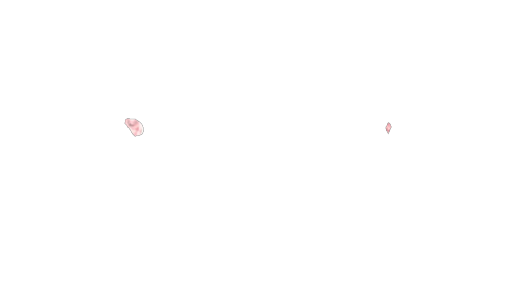

In [21]:
# Test the result of the model
import numpy as np
import matplotlib.pyplot as plt
image_url = "https://prod.titanencircle.com/on/demandware.static/-/Sites-Eyeplus-product-catalog/default/dw623fbf30/images/DK1087UFP3MORV_1_lar.jpg"
deeplab_model = load_model()
foreground, bin_mask = remove_background(deeplab_model, image_url)
plt.imshow(foreground)
plt.axis('off')
plt.show()

#

# The GroundingDino Model starts from here

In [ ]:
# Check for GPU support
!nvidia-smi

Thu Jun 19 11:45:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


## Install Grounding DINO and Segment Anything Model

Our project will use two groundbreaking designs - [Grounding DINO](https://github.com/IDEA-Research/GroundingDINO) - for zero-shot detection and [Segment Anything Model (SAM)](https://github.com/facebookresearch/segment-anything) - for converting boxes into segmentations. We have to install them first.


In [ ]:
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git

/content
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 463, done.
remote: Total 463 (delta 0), reused 0 (delta 0), pack-reused 463 (from 1)
Receiving objects: 100% (463/463), 12.91 MiB | 16.12 MiB/s, done.
Resolving deltas: 100% (220/220), done.


In [ ]:
%cd /content/GroundingDINO/groundingdino/models/GroundingDINO/csrc/MsDeformAttn
!sed -i 's/value.type()/value.scalar_type()/g' ms_deform_attn_cuda.cu
!sed -i 's/value.scalar_type().is_cuda()/value.is_cuda()/g' ms_deform_attn_cuda.cu

/content/GroundingDINO/groundingdino/models/GroundingDINO/csrc/MsDeformAttn


In [ ]:
%cd {HOME}/GroundingDINO
!git checkout -q 57535c5a79791cb76e36fdb64975271354f10251
!pip install -q -e .

/content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 k

In [ ]:
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-kscfvx85
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-kscfvx85
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=86e03db8ad587231ee21fda9b9a0230689cac6310425b15268013e7e85fd6c73
  Stored in directory: /tmp/pip-ephem-wheel-cache-zvr2u76p/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything


In [ ]:
!pip uninstall -y supervision
!pip install -q supervision==0.6.0

import supervision as sv
print(sv.__version__)

Found existing installation: supervision 0.4.0
Uninstalling supervision-0.4.0:
  Successfully uninstalled supervision-0.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
groundingdino 0.1.0 requires supervision==0.4.0, but you have supervision 0.6.0 which is incompatible.
0.6.0


In [ ]:
!pip install -q roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 89.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
groundingdino 0.1.0 requires supervision==0.4.0, but you have supervision 0.6.0 which is incompatible.


In [ ]:
import os

GROUNDING_DINO_CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(GROUNDING_DINO_CONFIG_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CONFIG_PATH))

/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


In [ ]:
%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/content
/content/weights


In [ ]:
import os

GROUNDING_DINO_CHECKPOINT_PATH = os.path.join(HOME, "weights", "groundingdino_swint_ogc.pth")
print(GROUNDING_DINO_CHECKPOINT_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CHECKPOINT_PATH))

/content/weights/groundingdino_swint_ogc.pth ; exist: True


### Download Segment Anything Model (SAM) Weights

As with Grounding DINO, in order to run SAM we need a weights file, which we must first download. We write the path to local weight file to `SAM_CHECKPOINT_PATH` variable and verify if the path is correct and the file exist on disk.

In [ ]:
%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


In [ ]:
import os

SAM_CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(SAM_CHECKPOINT_PATH, "; exist:", os.path.isfile(SAM_CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


## Load models

In [ ]:
import torch

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load Grounding DINO Model

In [ ]:
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import Model

grounding_dino_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH)

/content/GroundingDINO


/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

### Load Segment Anything Model (SAM)

In [ ]:
SAM_ENCODER_VERSION = "vit_h"

In [ ]:
from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH).to(device=DEVICE)
sam_predictor = SamPredictor(sam)

---

# The main Saree Extraction Pipeline Starts from Here

1. Import required packages

2. Define two helper functions for use
  * Enhance with class
  * Segment

3. Define a python function (pipeline) called saree_extract_pipeline that can take an image source and will store the extracted sarees in required output directory

In [ ]:
 # Importing required packages
from typing import List
import cv2
import supervision as sv
import numpy as np
from segment_anything import SamPredictor
import uuid
import warnings
warnings.filterwarnings("ignore")
import requests
import io

In [ ]:
# Define a helper function
def enhance_class_name(class_names: List[str]) -> List[str]:
    return [
        f"all {class_name}s"
        for class_name
        in class_names
    ]

In [ ]:
# Defining a helper function segment
def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

In [ ]:
# Create another helper function to remove the black background into white background
def black_to_white_bg(image, threshold=10):
    img = image
    # Convert to RGBA if not already
    if img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)

    # Create a mask where black pixels are
    lower_black = np.array([0, 0, 0], dtype=np.uint8)
    upper_black = np.array([threshold, threshold, threshold], dtype=np.uint8)
    mask = cv2.inRange(img[:, :, :3], lower_black, upper_black)

    # Apply transparency
    img[mask != 0] = [0, 0, 0, 0]  # Set matched pixels to transparent

    # Return the Image
    return img

# Importing some extra packages to work with image urls

In [ ]:
import requests
from PIL import Image
from io import BytesIO

In [ ]:
# Ensure output directory exists
output_dir = "/content/Extracted_Specs"
os.makedirs(output_dir, exist_ok = True)

# My primary Pipeline for extraction spaces from url goes here

The function name is modified_spec_extract_pipeline

In [ ]:
def modified_spec_extract_pipeline(image_url, output_path):
  # Read the image url using requests
  response = requests.get(image_url)
  if response.status_code != 200:
    raise Exception(f"=============Failed to load image from {image_url}=========================")
    print(response)
  # Read image bytes and open using PIL
  image_pil = Image.open(BytesIO(response.content)).convert("RGB")  # Convert to RGB to standardize
  image_rgb = np.array(image_pil)
  image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
  # Set the object, saree here
  CLASSES = ["spectacle frame"]
  # Set box and text threshold
  BOX_TRESHOLD = 0.40
  TEXT_TRESHOLD = 0.25
  # Get the detections using the first helper function
  detections = grounding_dino_model.predict_with_classes(
      image=image_rgb,
      classes=enhance_class_name(class_names=CLASSES),
      box_threshold=BOX_TRESHOLD,
      text_threshold=TEXT_TRESHOLD)

  # Detected objects with bounding Box
  box_annotator = sv.BoxAnnotator()
  labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _
    in detections]
  annotated_frame = box_annotator.annotate(scene=image_rgb.copy(), detections=detections, labels=labels)

  # Extracting the masks
  detections.mask = segment(
      sam_predictor=sam_predictor,
      image=image_bgr,
      xyxy=detections.xyxy)

  # Detected and Segmented objects
  box_annotator = sv.BoxAnnotator()
  mask_annotator = sv.MaskAnnotator()
  labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _
    in detections]
  annotated_image = mask_annotator.annotate(scene=image_rgb.copy(), detections=detections)
  annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

  # Assuming detections.mask contains the segmentation masks
  masks = detections.mask  # Shape: (N, H, W) where N = number of detections

  # Creating the Binary Mask
  # binary_mask = (detections.mask[0] * 255).astype(np.uint8) # when there is only 1 masks
  combined_mask = np.any(detections.mask, axis=0).astype(np.uint8) * 255

  # # Convert to 3-channel by repeating along a new axis
  # mask_3channel = np.repeat(combined_mask[:, :, np.newaxis], 3, axis=2)

  # # Extract the saree for image masks
  # extracted_saree_bgr = cv2.bitwise_and(image_bgr, mask_3channel)

  # Clean up the mask region
  kernel = np.ones((7,7), np.uint8)
  cleaned_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)
  cleaned_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_OPEN, kernel)
  blurred_mask = cv2.GaussianBlur(cleaned_mask, (9,9), 0)

  # Create RGBA image with transparency from mask
  image_rgba = image_pil.convert("RGBA")
  data = np.array(image_rgba)
  r, g, b, _ = data.T

  # Apply mask: If mask is 0, set alpha to 0 (transparent)
  # alpha = combined_mask.astype(np.uint8)
  data[..., 3] = blurred_mask.astype(np.uint8)

  # Convert back to PIL Image
  result = Image.fromarray(data)

  # Remove any remaining white pixels in the image
  result_np = np.array(result)
  near_white = np.all(result_np[..., :3] > 220, axis=-1)
  result_np[near_white, 3] = 0
  result = Image.fromarray(result_np)

  # # Store the image without background
  # image_rgb_clean = cv2.cvtColor(extracted_saree_bgr, cv2.COLOR_BGR2RGB)
  # extracted_saree_rgba = Image.fromarray(image_rgb_clean).convert("RGBA")
  # result = remove(extracted_saree_rgba)
  result.save(output_path)
  print(f"SUCCESSFUL: Saved to: {output_path}")

  # Show the output results
  import matplotlib.pyplot as plt
  sv.plot_image(annotated_frame, (6,6)) # Detections
  sv.plot_image(annotated_image, (6,6)) # Segmentations
  # sv.plot_image(image_rgb_clean, (6,6)) # Extracted Saree with background
  plt.imshow(result) # Final extrcated image
  plt.axis('off')
  plt.show()

SUCCESSFUL: Saved to: /content/Extracted_Spec.png


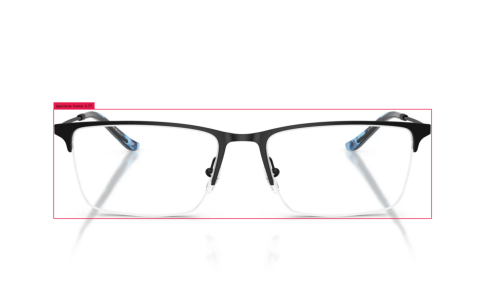

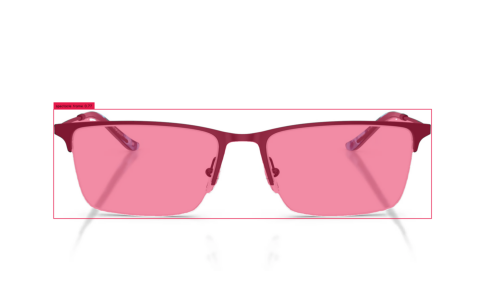

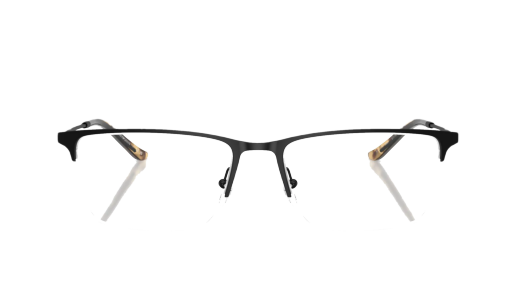

In [ ]:
img_url = "https://prod.titanencircle.com/on/demandware.static/-/Sites-Eyeplus-product-catalog/default/dwf6ffb150/images/fea1171300155_8_lar.jpg"
output_path = "/content/Extracted_Spec.png"
modified_spec_extract_pipeline(img_url, output_path)

# For sunglasses, some white pixel may occur. We have to ommit them

In [ ]:
# def spec_extract_pipeline(image_path):
#   # Set the object, saree here
#   CLASSES = ["spectacle"]

#   # Set box and text threshold
#   BOX_TRESHOLD = 0.20
#   TEXT_TRESHOLD = 0.15

#   # Read the image from the provided saree path
#   image = cv2.imread(image_path)

#   # Get the detections using the first helper function
#   detections = grounding_dino_model.predict_with_classes(
#       image=image,
#       classes=enhance_class_name(class_names=CLASSES),
#       box_threshold=BOX_TRESHOLD,
#       text_threshold=TEXT_TRESHOLD)

#   # annotate image with detections
#   box_annotator = sv.BoxAnnotator()
#   labels = [
#     f"{CLASSES[class_id]} {confidence:0.2f}"
#     for _, _, confidence, class_id, _
#     in detections]
#   annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

#   # Extracting the masks
#   detections.mask = segment(
#       sam_predictor=sam_predictor,
#       image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
#       xyxy=detections.xyxy)

#   # annotate image with detections
#   box_annotator = sv.BoxAnnotator()
#   mask_annotator = sv.MaskAnnotator()
#   labels = [
#     f"{CLASSES[class_id]} {confidence:0.2f}"
#     for _, _, confidence, class_id, _
#     in detections]
#   annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
#   annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

#   # Assuming detections.mask contains the segmentation masks
#   masks = detections.mask  # Shape: (N, H, W) where N = number of detections

#   # Creating the Binary Mask
#   binary_mask = (detections.mask[0] * 255).astype(np.uint8) # when there is only 1 masks

#   ## Convert to 3-channel by repeating along a new axis
#   mask_3channel = np.repeat(binary_mask[:, :, np.newaxis], 3, axis=2)

#   # Extract the saree for image masks
#   extracted_spec_bgr = cv2.bitwise_and(image, mask_3channel)
#   # Converting the image into alpha channel
#   extracted_spec_rgba = cv2.cvtColor(extracted_spec_bgr, cv2.COLOR_BGR2RGBA)

#   white_threshold = 150

#   # Get individual color channels and the alpha channel
#   # OpenCV's RGBA is (B, G, R, A)
#   b, g, r, a = extracted_spec_rgba[:, :, 0], extracted_spec_rgba[:, :, 1], \
#                  extracted_spec_rgba[:, :, 2], extracted_spec_rgba[:, :, 3]

#   # Create a boolean mask for pixels that are predominantly white
#   # and are currently opaque (alpha > 0), so we don't affect already transparent areas.
#   is_white_pixel = (r > white_threshold) & \
#                     (g > white_threshold) & \
#                     (b > white_threshold) & \
#                     (a > 0)

#   # Set the alpha channel to 0 (fully transparent) for these white pixels
#   a[is_white_pixel] = 0

#   # Apply the modified alpha channel back
#   extracted_spec_rgba[:, :, 3] = a

#   # Convert the NumPy RGBA array back to a PIL Image (if remove() expects PIL Image)
#   # or keep as NumPy array if remove() can handle it. rembg's remove typically
#   # works best with PIL Image.
#   extracted_spec_with_alpha_pil = Image.fromarray(extracted_spec_rgba, 'RGBA')

#   # --- NEW ADDITION END ---

#   # Now, run rembg's remove function on the image that already has some transparency applied.
#   # This step will further refine the background removal and handle any remaining complex edges.
#   extracted_spec_final = remove(extracted_spec_with_alpha_pil)

#   # --- Visualization (ensure plots work with RGBA/PIL images if they convert internally) ---
#   sv.plot_image(annotated_frame, size=(6, 6))
#   sv.plot_image(annotated_image, size=(6, 6))
#   sv.plot_image(binary_mask, size=(6, 6))
#   sv.plot_image(cv2.cvtColor(extracted_spec_bgr, cv2.COLOR_BGR2RGB), size=(6, 6)) # Plot BGR as RGB for correct colors
#   # For plotting RGBA/PIL images, sv.plot_image might need the image to be converted to RGB or handled internally.
#   # If sv.plot_image doesn't handle PIL.Image directly, convert it:
#   sv.plot_image(np.array(extracted_spec_with_alpha_pil)[:,:,:3], size=(6, 6)) # Plot RGB channels of RGBA
#   sv.plot_image(np.array(extracted_spec_final)[:,:,:3], size=(6, 6)) # Plot RGB channels of final RGBA

#   # Save the final result (PNG supports alpha channel)
#   # cv2.imwrite does not handle PIL Image directly. Convert PIL to NumPy (RGBA)
#   # then save, or use pil_image.save()
#   extracted_spec_final.save("/content/TryTest.png")
#   print("Final processed image saved to /content/TryTest.png")

#   return extracted_spec_final

In [ ]:
# spec_extract_pipeline("/content/OrgSpec2.jpg")

# Normal Spec detection and bg removal

In [ ]:
# import rembg
# def spec_extract_pipeline(image_path, output_path):
#   # Set the object, saree here
#   CLASSES = ["spectacle"]

#   # Set box and text threshold
#   BOX_TRESHOLD = 0.20
#   TEXT_TRESHOLD = 0.15

#   # Read the image from the provided saree path
#   image = cv2.imread(image_path)

#   # Get the detections using the first helper function
#   detections = grounding_dino_model.predict_with_classes(
#       image=image,
#       classes=enhance_class_name(class_names=CLASSES),
#       box_threshold=BOX_TRESHOLD,
#       text_threshold=TEXT_TRESHOLD)

#   # annotate image with detections
#   box_annotator = sv.BoxAnnotator()
#   labels = [
#     f"{CLASSES[class_id]} {confidence:0.2f}"
#     for _, _, confidence, class_id, _
#     in detections]
#   annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

#   # Extracting the masks
#   detections.mask = segment(
#       sam_predictor=sam_predictor,
#       image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
#       xyxy=detections.xyxy)

#   # annotate image with detections
#   box_annotator = sv.BoxAnnotator()
#   mask_annotator = sv.MaskAnnotator()
#   labels = [
#     f"{CLASSES[class_id]} {confidence:0.2f}"
#     for _, _, confidence, class_id, _
#     in detections]
#   annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
#   annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

#   # Assuming detections.mask contains the segmentation masks
#   masks = detections.mask  # Shape: (N, H, W) where N = number of detections

#   # Creating the Binary Mask
#   binary_mask = (detections.mask[0] * 255).astype(np.uint8) # when there is only 1 masks

#   ## Convert to 3-channel by repeating along a new axis
#   mask_3channel = np.repeat(binary_mask[:, :, np.newaxis], 3, axis=2)

#   # Extract the saree for image masks
#   extracted_spec = cv2.bitwise_and(image, mask_3channel)

#   # # Observe the detections
#   # sv.plot_image(annotated_frame, size=(6, 6))
#   # sv.plot_image(annotated_image, size=(6, 6))
#   # sv.plot_image(binary_mask, size=(6, 6))

#   # extracted_spec = cv2.cvtColor(extracted_spec, cv2.COLOR_BGR2RGB)
#   # extracted_spec = Image.fromarray(extracted_spec)

#   # final_img = rembg.remove(extracted_spec)
#   # final_img.save(output_path)
#   # import matplotlib.pyplot as plt
#   # plt.imshow(extracted_spec)
#   # plt.axis('off')
#   # plt.show()

#   # Store the image with white background
#   white_bg = black_to_white_bg(extracted_spec)

#   # Convert the image into no-background--transparent
#   img = Image.fromarray(white_bg).convert("RGBA")
#   datas = img.getdata()
#   newData = []
#   for item in datas:
#     # Detect white pixels (you can adjust the tolerance if needed)
#     if item[0] > 240 and item[1] > 240 and item[2] > 240:
#         newData.append((255, 255, 255, 0))  # Set alpha to 0 (transparent)
#     else:
#         newData.append(item)
#   # Save image with transparency
#   img.putdata(newData)
#   img.save(output_path)

In [ ]:
# spec_extract_pipeline("/content/OrgSpec2.jpg", "/content/TryTest2.png")

# The main loop to read images from urls

In [ ]:
# # Loop through all the image urls and apply on the function
# for idx, (product_id, url) in enumerate(testspecs):
#     try:
#         print(f"Processing {idx+1}/{len(testspecs)}: {product_id} -> {url}")
#         response = requests.get(url)
#         if response.status_code != 200:
#             print(response)
#             print("-------------------Failed to download image.-------------------------")
#             continue

#         image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
#         image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

#         if image is None:
#             print("---------------Could not decode image-----------------------")
#             continue

#         result_img = spec_extract_pipeline(image)

#         if result_img is not None:
#             filename = f"Extracted_Bag_{product_id}.png"
#             result_img.save(os.path.join(output_dir, filename))
#             print(f"SUCCESSFUL:Saved to: {output_dir} as {filename}")
#         else:
#             print("----------------------No result generated.--------------------")

#     except Exception as e:
#         print(f"----------------Error with image {idx+1}: {e}--------------------")

# To delete the files inside a folder

In [ ]:
# # Delete all file from the Extracted_Watch folder
# import os

# folder_path = "/content/Extracted_Watch"

# for filename in os.listdir(folder_path):
#     file_path = os.path.join(folder_path, filename)

#     # Delete only files, skip folders
#     if os.path.isfile(file_path):
#         os.remove(file_path)

# To know how many files are there in a folder

In [ ]:
# # Check the number of files in the output directory
# import glob

# folder_path = "/content/Extracted_Specs"

# num_files = len(glob.glob(folder_path + "/*"))

# print(f"Number of files in the folder: {num_files}")

# To convert the folder in a zip format

In [ ]:
# # To convert the created folder into zip folder
# import shutil

# # Replace 'your_folder' with the actual folder name
# shutil.make_archive('/content/Extracted_Specs', 'zip', '/content/Extracted_Specs')

'/content/Extracted_Specs.zip'

# To download the folder in local file system

In [ ]:
# # To download the files in local system
# from google.colab import files
# files.download('/content/Extracted_Specs.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>